<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Using-.groupby()-without-DateTime-Index" data-toc-modified-id="Using-.groupby()-without-DateTime-Index-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Using .groupby() without DateTime Index</a></span></li><li><span><a href="#Using-.loc[-]" data-toc-modified-id="Using-.loc[-]-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Using .loc[ ]</a></span></li><li><span><a href="#Using-Date-Parts" data-toc-modified-id="Using-Date-Parts-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Using Date Parts</a></span></li><li><span><a href="#Using-.groupby()-with-DateTime-Index" data-toc-modified-id="Using-.groupby()-with-DateTime-Index-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Using .groupby() with DateTime Index</a></span></li><li><span><a href="#FB-Prophet-Forecasting" data-toc-modified-id="FB-Prophet-Forecasting-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>FB Prophet Forecasting</a></span><ul class="toc-item"><li><span><a href="#Split-Data" data-toc-modified-id="Split-Data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Split Data</a></span></li><li><span><a href="#Build-Model" data-toc-modified-id="Build-Model-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Build Model</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
from math import sqrt

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.plotting.register_matplotlib_converters()


plt.rc('figure', figsize=(11, 9))
plt.rc('font', size=13)

import requests
import os
from datetime import timedelta, datetime as dt

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_forecast_component

import warnings
warnings.filterwarnings("ignore")

import acquire_walkthrough

In [2]:
df = acquire_walkthrough.get_store_data()
df.head()

,sale_amount,sale_id,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14
sale_date,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,13.0,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
2013-01-01 00:00:00+00:00,26.0,211817,12018 Perrin Beitel Rd,San Antonio,7,TX,78217,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211
2013-01-01 00:00:00+00:00,27.0,832657,12018 Perrin Beitel Rd,San Antonio,7,TX,78217,Mama Marys,46,Pizza Sauce,4.65,35457770664,35457770664
2013-01-01 00:00:00+00:00,54.0,213643,15000 San Pedro Ave,San Antonio,8,TX,78232,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211
2013-01-01 00:00:00+00:00,35.0,215469,735 SW Military Dr,San Antonio,9,TX,78221,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211


In [3]:
df.shape

(913000, 13)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 00:00:00+00:00 to 2017-12-31 00:00:00+00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sale_amount    913000 non-null  float64
 1   sale_id        913000 non-null  int64  
 2   store_address  913000 non-null  object 
 3   store_city     913000 non-null  object 
 4   store_id       913000 non-null  int64  
 5   store_state    913000 non-null  object 
 6   store_zipcode  913000 non-null  int64  
 7   item_brand     913000 non-null  object 
 8   item_id        913000 non-null  int64  
 9   item_name      913000 non-null  object 
 10  item_price     913000 non-null  float64
 11  item_upc12     913000 non-null  int64  
 12  item_upc14     913000 non-null  int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 97.5+ MB


In [5]:
# We have 1826 unique dates in the DateTime Index

df.index.nunique()

1826

In [6]:
# Jan 1, 2013 first day in dataset

df.index.min()

Timestamp('2013-01-01 00:00:00+0000', tz='UTC')

In [7]:
# Dec 31, 2017 last day in dataset

df.index.max()

Timestamp('2017-12-31 00:00:00+0000', tz='UTC')

In [8]:
timedelta(df.index.nunique())

datetime.timedelta(days=1826)

In [9]:
# Each of 10 store_ids has the an equal number of observations

df.store_id.value_counts()

10    91300
9     91300
8     91300
7     91300
6     91300
5     91300
4     91300
3     91300
2     91300
1     91300
Name: store_id, dtype: int64

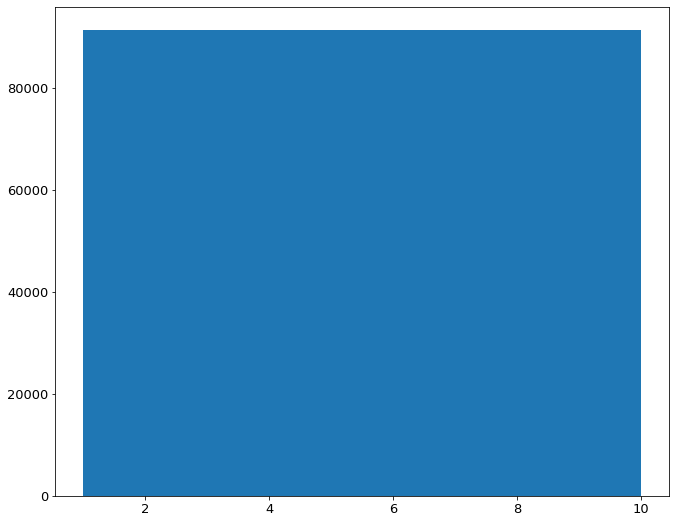

In [10]:
plt.hist(df.store_id)
plt.show()

In [11]:
# There are 50 unique items in our dataset

df.item_id.nunique()

50

In [12]:
# It looks like equal numbers of sales of each item

df.item_id.value_counts().describe()

count       50.0
mean     18260.0
std          0.0
min      18260.0
25%      18260.0
50%      18260.0
75%      18260.0
max      18260.0
Name: item_id, dtype: float64

In [13]:
# We do have an observation where 0.0 is. the sale_amount

df.sale_amount.value_counts(dropna=False).sort_index()

0.0        1
1.0        4
2.0       25
3.0       91
4.0      215
        ... 
208.0      1
209.0      1
210.0      1
214.0      1
231.0      1
Name: sale_amount, Length: 213, dtype: int64

In [14]:
df[df.sale_amount == 0.0]

,sale_amount,sale_id,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14
sale_date,,,,,,,,,,,,,
2014-01-15 00:00:00+00:00,0.0,64290,1015 S WW White Rd,San Antonio,6,TX,78220,Boars Head,4,Boars Head Sliced White American Cheese - 120 Ct,3.14,208528800007,208528800007


In [15]:
temp_df = df[df.sale_amount != 0]
temp_df.count()

sale_amount      912999
sale_id          912999
store_address    912999
store_city       912999
store_id         912999
store_state      912999
store_zipcode    912999
item_brand       912999
item_id          912999
item_name        912999
item_price       912999
item_upc12       912999
item_upc14       912999
dtype: int64

## Using .groupby() without DateTime Index

In [16]:
# This tells us each store sold one of each item on the first day of the dataset

first_sale_per_storeitem = temp_df.reset_index().groupby(['store_id','item_id']).sale_date.min()
print(f'{len(first_sale_per_storeitem)} = 10 stores x 50 items')
first_sale_per_storeitem[-15:]

500 = 10 stores x 50 items


store_id  item_id
10        36        2013-01-01 00:00:00+00:00
          37        2013-01-01 00:00:00+00:00
          38        2013-01-01 00:00:00+00:00
          39        2013-01-01 00:00:00+00:00
          40        2013-01-01 00:00:00+00:00
          41        2013-01-01 00:00:00+00:00
          42        2013-01-01 00:00:00+00:00
          43        2013-01-01 00:00:00+00:00
          44        2013-01-01 00:00:00+00:00
          45        2013-01-01 00:00:00+00:00
          46        2013-01-01 00:00:00+00:00
          47        2013-01-01 00:00:00+00:00
          48        2013-01-01 00:00:00+00:00
          49        2013-01-01 00:00:00+00:00
          50        2013-01-01 00:00:00+00:00
Name: sale_date, dtype: datetime64[ns, UTC]

In [17]:
# This tells us each store sold one of each item on the last day of the dataset

last_sale_per_storeitem = temp_df.reset_index().groupby(['store_id','item_id'])[['sale_date']].max()
print(f'{len(last_sale_per_storeitem)} ')
last_sale_per_storeitem[:15]

500 


sale_date
store_id item_id                          
1        1       2017-12-31 00:00:00+00:00
         2       2017-12-31 00:00:00+00:00
         3       2017-12-31 00:00:00+00:00
         4       2017-12-31 00:00:00+00:00
         5       2017-12-31 00:00:00+00:00
         6       2017-12-31 00:00:00+00:00
         7       2017-12-31 00:00:00+00:00
         8       2017-12-31 00:00:00+00:00
         9       2017-12-31 00:00:00+00:00
         10      2017-12-31 00:00:00+00:00
         11      2017-12-31 00:00:00+00:00
         12      2017-12-31 00:00:00+00:00
         13      2017-12-31 00:00:00+00:00
         14      2017-12-31 00:00:00+00:00
         15      2017-12-31 00:00:00+00:00

In [18]:
# This tells us each store sold at least one of each item each day in the dataset

days_per_storeitem = df.reset_index().groupby(['store_id','item_id']).sale_date.nunique()

days_per_storeitem.unique()

array([1826])

In [19]:
df.groupby(['store_id','item_id']).nunique()

sale_amount  sale_id  store_address  store_city  store_id  \
store_id item_id                                                              
1        1                 41     1826              1           1         1   
         2                 90     1826              1           1         1   
         3                 59     1826              1           1         1   
         4                 39     1826              1           1         1   
         5                 34     1826              1           1         1   
...                       ...      ...            ...         ...       ...   
10       46                97     1826              1           1         1   
         47                48     1826              1           1         1   
         48                87     1826              1           1         1   
         49                60     1826              1           1         1   
         50               108     1826              1           1         1   

                  store_state  store_zipcode  item_brand  item_id  item_name  \
store_id item_id                                                               
1        1                  1              1           1        1          1   
         2                  1              1           1        1          1   
         3                  1              1           1        1          1   
         4                  1              1           1        1          1   
         5                  1              1           1        1          1   
...                       ...            ...         ...      ...        ...   
10       46                 1              1           1        1          1   
         47                 1              1           1        1          1   
         48                 1              1           1        1          1   
         49                 1              1           1        1          1   
         50                 1              1           1        1          1   

                  item_price  item_upc12  item_upc14  
store_id item_id                                      
1        1                 1           1           1  
         2                 1           1           1  
         3                 1           1           1  
         4                 1           1           1  
         5                 1           1           1  
...                      ...         ...         ...  
10       46                1           1           1  
         47                1           1           1  
         48                1           1           1  
         49                1           1           1  
         50                1           1           1  

[500 rows x 13 columns]

## Using .loc[ ]

In [20]:
# .loc indexes using a string, so we can pass a specific date and return those rows
# We see this date returns 500 rows, 10 stores, 50 items, 1 day = 500 observations

print(len(df.loc['2016-02-03']))
df.loc['2016-02-03'].head(3)

500


,sale_amount,sale_id,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14
sale_date,,,,,,,,,,,,,
2016-02-03 00:00:00+00:00,28.0,41301,2118 Fredericksburg Rdj,San Antonio,3,TX,78201,Earths Best,3,Earths Best Organic Fruit Yogurt Smoothie Mixe...,2.43,23923330139,23923330139
2016-02-03 00:00:00+00:00,16.0,742485,12018 Perrin Beitel Rd,San Antonio,7,TX,78217,P.f. Changs,41,P.f. Changs Home Menu Meal For Two Beef With B...,5.62,31000670016,31000670016
2016-02-03 00:00:00+00:00,24.0,733355,9255 FM 471 West,San Antonio,2,TX,78251,P.f. Changs,41,P.f. Changs Home Menu Meal For Two Beef With B...,5.62,31000670016,31000670016


In [21]:
# Select a month, 14_000 observations in February of 2013

print(len(df.loc['2013-02']))
df.loc['2013-02'].head(3)

14000


,sale_amount,sale_id,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14
sale_date,,,,,,,,,,,,,
2013-02-01 00:00:00+00:00,22.0,36552,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Earths Best,3,Earths Best Organic Fruit Yogurt Smoothie Mixe...,2.43,23923330139,23923330139
2013-02-01 00:00:00+00:00,40.0,858252,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Dove,48,Dove Men + Care Antiperspirant Deodorant Cool ...,3.72,79400271631,79400271631
2013-02-01 00:00:00+00:00,27.0,832688,12018 Perrin Beitel Rd,San Antonio,7,TX,78217,Mama Marys,46,Pizza Sauce,4.65,35457770664,35457770664


In [22]:
# Select a date range like a year, 183_500 observations in this particular year

print(len(df.loc['2016-02-03' : '2017-02-03']))
df.loc['2016-02-03' : '2017-02-03'].head(3)

183500


,sale_amount,sale_id,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14
sale_date,,,,,,,,,,,,,
2016-02-03 00:00:00+00:00,28.0,41301,2118 Fredericksburg Rdj,San Antonio,3,TX,78201,Earths Best,3,Earths Best Organic Fruit Yogurt Smoothie Mixe...,2.43,23923330139,23923330139
2016-02-03 00:00:00+00:00,16.0,742485,12018 Perrin Beitel Rd,San Antonio,7,TX,78217,P.f. Changs,41,P.f. Changs Home Menu Meal For Two Beef With B...,5.62,31000670016,31000670016
2016-02-03 00:00:00+00:00,24.0,733355,9255 FM 471 West,San Antonio,2,TX,78251,P.f. Changs,41,P.f. Changs Home Menu Meal For Two Beef With B...,5.62,31000670016,31000670016


## Using Date Parts

In [23]:
df['year'] = df.index.year
df.head(1)

,sale_amount,sale_id,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,year
sale_date,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,13.0,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,2013


In [24]:
df['month'] = df.index.month
df.head(1)

,sale_amount,sale_id,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,year,month
sale_date,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,13.0,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,2013,1


In [25]:
# If you have upgraded your pandas, use .day_name(), if not, .weekday_name

pd.__version__

'1.0.3'

In [26]:
df['weekday'] = df.index.day_name()
df.head(1)

,sale_amount,sale_id,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,year,month,weekday
sale_date,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,13.0,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,2013,1,Tuesday


In [27]:
# I want to convert some of these int64 to objects

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 00:00:00+00:00 to 2017-12-31 00:00:00+00:00
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sale_amount    913000 non-null  float64
 1   sale_id        913000 non-null  int64  
 2   store_address  913000 non-null  object 
 3   store_city     913000 non-null  object 
 4   store_id       913000 non-null  int64  
 5   store_state    913000 non-null  object 
 6   store_zipcode  913000 non-null  int64  
 7   item_brand     913000 non-null  object 
 8   item_id        913000 non-null  int64  
 9   item_name      913000 non-null  object 
 10  item_price     913000 non-null  float64
 11  item_upc12     913000 non-null  int64  
 12  item_upc14     913000 non-null  int64  
 13  year           913000 non-null  int64  
 14  month          913000 non-null  int64  
 15  weekday        913000 non-null  object 
dtypes: float64(2), int64(8), obj

In [28]:
# now our only numeric columns are sale_amount and item_price

df = df.astype({'sale_id': object, 'store_id': object, 'store_zipcode': object, 'item_id': object, 'item_upc12': object, 'item_upc14': object, 'year': 'category', 'month': 'category', 'weekday': 'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 00:00:00+00:00 to 2017-12-31 00:00:00+00:00
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   sale_amount    913000 non-null  float64 
 1   sale_id        913000 non-null  object  
 2   store_address  913000 non-null  object  
 3   store_city     913000 non-null  object  
 4   store_id       913000 non-null  object  
 5   store_state    913000 non-null  object  
 6   store_zipcode  913000 non-null  object  
 7   item_brand     913000 non-null  object  
 8   item_id        913000 non-null  object  
 9   item_name      913000 non-null  object  
 10  item_price     913000 non-null  float64 
 11  item_upc12     913000 non-null  object  
 12  item_upc14     913000 non-null  object  
 13  year           913000 non-null  category
 14  month          913000 non-null  category
 15  weekday        913000 non-null  category
dtypes: categor

## Using .groupby() with DateTime Index

In [29]:
df.groupby('sale_date').sale_amount.sum().head()

sale_date
2013-01-01 00:00:00+00:00    13696.0
2013-01-02 00:00:00+00:00    13678.0
2013-01-03 00:00:00+00:00    14488.0
2013-01-04 00:00:00+00:00    15677.0
2013-01-05 00:00:00+00:00    16237.0
Name: sale_amount, dtype: float64

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


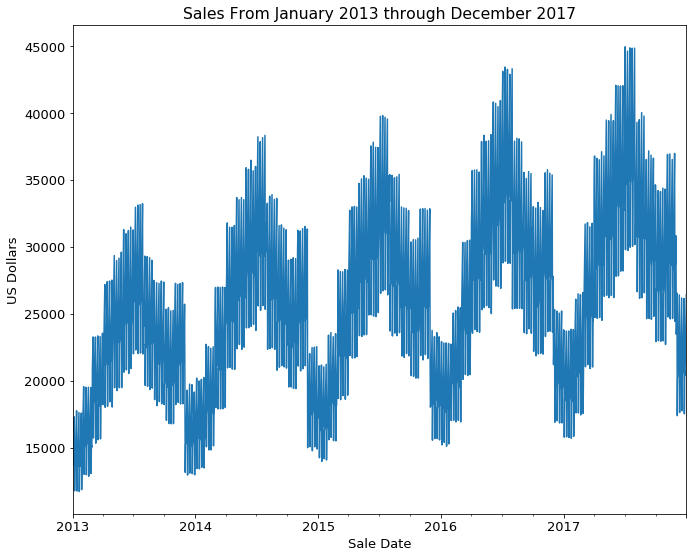

In [30]:
# Overall sales are trending upward from 2013 to 2017

df.groupby('sale_date').sale_amount.sum().plot()

plt.title('Sales From January 2013 through December 2017')
plt.xlabel('Sale Date')
plt.ylabel('US Dollars')
plt.show()

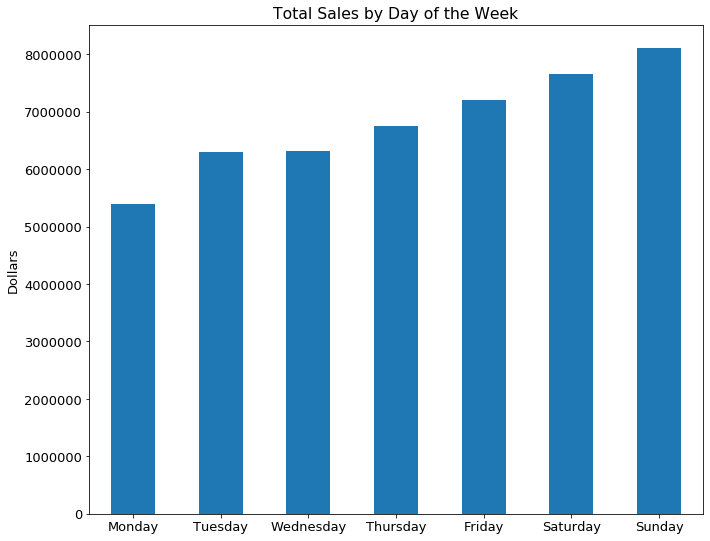

In [31]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df.groupby('weekday').sale_amount.sum().reindex(cats).plot(kind='bar')

plt.xlabel('')
plt.ylabel('Dollars')
plt.xticks(rotation=0)
plt.title('Total Sales by Day of the Week')
plt.show()

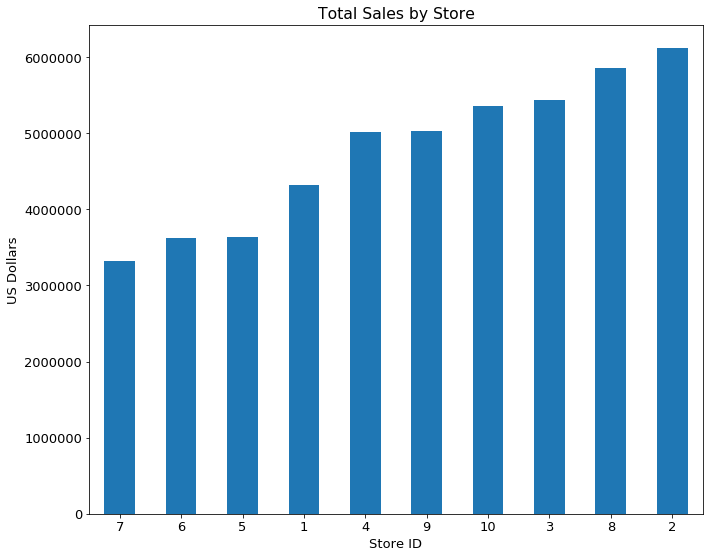

In [32]:
df.groupby('store_id').sale_amount.sum().sort_values().plot.bar()

plt.xlabel('Store ID')
plt.ylabel('US Dollars')
plt.title('Total Sales by Store')
plt.xticks(rotation=0)
plt.show()

## FB Prophet Forecasting

In [33]:
df.head(2)

,sale_amount,sale_id,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,year,month,weekday
sale_date,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,13.0,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,2013,1,Tuesday
2013-01-01 00:00:00+00:00,26.0,211817,12018 Perrin Beitel Rd,San Antonio,7,TX,78217,Mueller,12,Mueller Sport Care Basic Support Level Medium ...,8.40,74676640211,74676640211,2013,1,Tuesday


In [72]:
# Create the DataFrame required by FB Prophet

prophet_df = (df.
        assign(ds=pd.to_datetime(df.index)).
        sort_values('ds').
        assign(y=df.sale_amount * df.item_price).
        groupby(['ds'])[['y']].sum().
              reset_index()
    )

In [73]:
# Take care of time zone issue

prophet_df.ds = prophet_df.ds.dt.tz_convert(None)

In [74]:
prophet_df.head()

,ds,y
0,2013-01-01,73844.01
1,2013-01-02,73570.58
2,2013-01-03,78169.48
3,2013-01-04,84467.73
4,2013-01-05,87621.85


In [75]:
prophet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1826 non-null   datetime64[ns]
 1   y       1826 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.7 KB


### Split Data

In [77]:
train = prophet_df.set_index('ds')[:'2015'].reset_index()
print(train.shape)
train.head()

(1095, 2)


,ds,y
0,2013-01-01,73844.01
1,2013-01-02,73570.58
2,2013-01-03,78169.48
3,2013-01-04,84467.73
4,2013-01-05,87621.85


In [78]:
validate = prophet_df.set_index('ds')['2016'].reset_index()
print(validate.shape)
validate.head()

(366, 2)


,ds,y
0,2016-01-01,107875.26
1,2016-01-02,114330.43
2,2016-01-03,123144.91
3,2016-01-04,80873.97
4,2016-01-05,95429.90


In [79]:
test = prophet_df.set_index('ds')['2017'].reset_index()
print(test.shape)
test.head()

(365, 2)


,ds,y
0,2017-01-01,127262.71
1,2017-01-02,85329.98
2,2017-01-03,100389.65
3,2017-01-04,99454.59
4,2017-01-05,107613.80


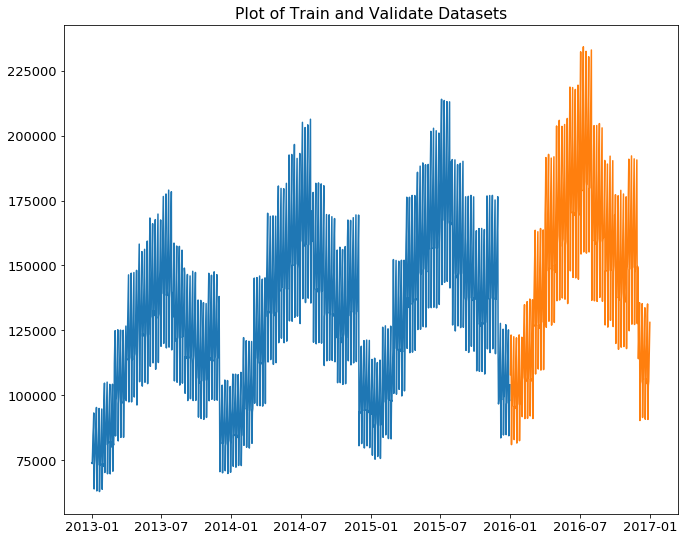

In [81]:
plt.plot(train.set_index('ds'))
plt.plot(validate.set_index('ds'))

plt.title('Plot of Train and Validate Datasets')
plt.show()

In [82]:
print(train.shape)
print(train.head(2))
print(train.tail(2))

(1095, 2)
          ds         y
0 2013-01-01  73844.01
1 2013-01-02  73570.58
             ds          y
1093 2015-12-30   97773.10
1094 2015-12-31  103969.42


In [83]:
print(validate.shape)
print(validate.head(2))
print(validate.tail(2))

(366, 2)
          ds          y
0 2016-01-01  107875.26
1 2016-01-02  114330.43
            ds          y
364 2016-12-30  120033.64
365 2016-12-31  128009.31


In [84]:
print(test.shape)
print(test.head(2))
print(test.tail(2))

(365, 2)
          ds          y
0 2017-01-01  127262.71
1 2017-01-02   85329.98
            ds          y
363 2017-12-30  134903.07
364 2017-12-31  140905.74


In [85]:
train['cap'] = 600
train['floor'] = 100
train.head(2)

,ds,y,cap,floor
0,2013-01-01,73844.01,600,100
1,2013-01-02,73570.58,600,100


### Build Model

In [86]:
help(Prophet)

Help on class Prophet in module fbprophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear' or 'logistic' to specify a linear or logistic
 |      trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_changepoints potential changepoints are selected uniformly from
 |      the 

In [87]:
model = Prophet(growth = 'logistic', daily_seasonality = True, changepoint_range = 0.9)
model.add_country_holidays(country_name='US')
model.fit(train)

In [88]:
model.train_holiday_names

0                  New Year's Day
1     Martin Luther King, Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10    Independence Day (Observed)
dtype: object

In [89]:
future = model.make_future_dataframe(periods = len(validate))
future['cap'] = 600
future['floor'] = 100

In [90]:
forecast = model.predict(future)

In [91]:
forecast.head(2)

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,571.221334,600,100,64267.956811,94784.374268,571.221334,571.221334,0.0,0.0,...,-9903.923270,-9903.923270,-9903.923270,-36941.489899,-36941.489899,-36941.489899,0.0,0.0,0.0,80024.598434
1,2013-01-02,571.265672,600,100,68941.373424,97374.548320,571.265672,571.265672,0.0,0.0,...,-9767.508585,-9767.508585,-9767.508585,-37568.836603,-37568.836603,-37568.836603,0.0,0.0,0.0,83255.961296


In [92]:
# select the dates for the holidays listed, and extract the sales predictions during those holidays
forecast[(forecast['Christmas Day'] + 
          forecast['Thanksgiving'] + 
          forecast["New Year's Day"]).abs() > 0]\
        [['ds', 'Christmas Day', 'Thanksgiving', "New Year's Day"]][-10:]

,ds,Christmas Day,Thanksgiving,New Year's Day
358,2013-12-25,3217.173707,0.00000,0.000000
365,2014-01-01,0.000000,0.00000,-3722.250542
695,2014-11-27,0.000000,16364.78427,0.000000
723,2014-12-25,3217.173707,0.00000,0.000000
730,2015-01-01,0.000000,0.00000,-3722.250542
1059,2015-11-26,0.000000,16364.78427,0.000000
1088,2015-12-25,3217.173707,0.00000,0.000000
1095,2016-01-01,0.000000,0.00000,-3722.250542
1423,2016-11-24,0.000000,16364.78427,0.000000
1454,2016-12-25,3217.173707,0.00000,0.000000


In [93]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1456,2016-12-27,86218.245183,70759.985490,99933.739492
1457,2016-12-28,85981.118664,70959.920718,100597.817835
1458,2016-12-29,93660.997903,79179.833165,108243.766310
1459,2016-12-30,102008.368576,88150.793818,117003.662537
1460,2016-12-31,110440.551752,95587.687845,125245.545652


In [96]:
from sklearn.metrics import mean_squared_error

eval_df = pd.merge(prophet_df, forecast[['ds', 'yhat']], how = 'inner', on = 'ds')

rmse = sqrt(mean_squared_error(eval_df.y, eval_df.yhat))
print(f'The rmse for our forecast model is: {rmse}')

The rmse for our forecast model is: 15130.367605919084


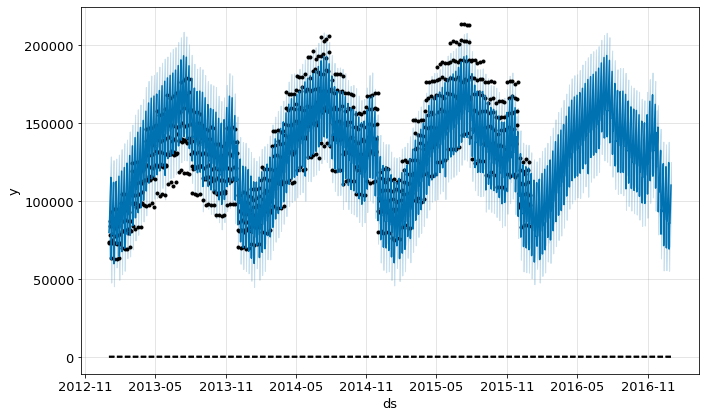

In [95]:
model.plot(forecast)
plt.show()

AttributeError: 'DatetimeIndex' object has no attribute 'weekday_name'

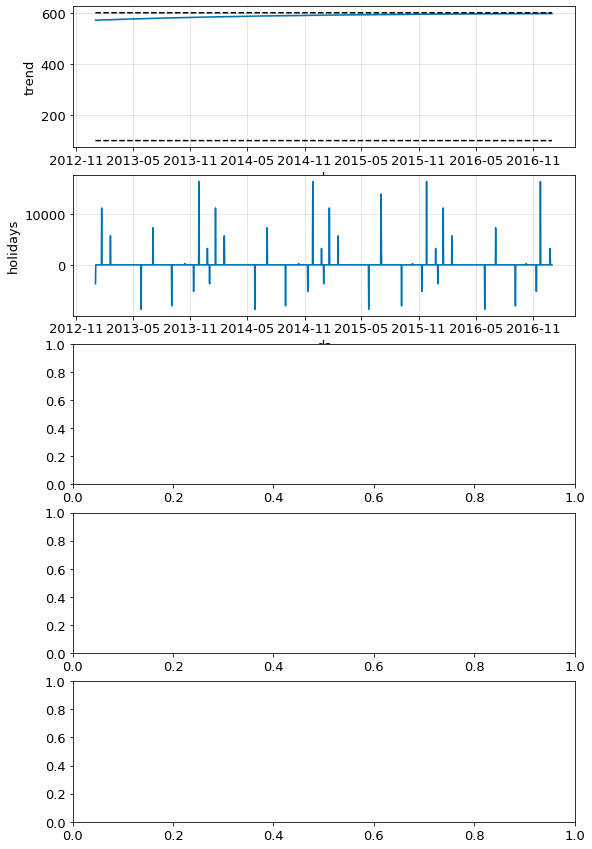

In [98]:
model.plot_components(forecast, 'holidays')


In [ ]:
forecast['cutoff'] = train.ds.iloc[-1]

In [ ]:
y = pd.DataFrame(df[:'2016']['y'])
forecast['y'] = y.reset_index()

In [ ]:
gdf = acquire_walkthrough.german_energy_csv()
gdf.head()

In [ ]:
gdf.info()

In [ ]:
gdf.groupby('Date').Consumption.sum().plot()

In [ ]:
gdf[['Consumption', 'Wind+Solar']].asfreq('Q').plot()